# Gradient Descent / Ascent

This tutorial is for illustrating the plain vanilla gradient descent algorithm. While this is valuable for educational purposes, it's common in real-world applications to utilize advanced libraries like PyTorch or scikit-learn, which offer more refined and efficient implementations.

## Gradient Ascent on a function 

This example shows a basic implementation of the gradient ascent algorithm.

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
plt.style.use('bmh')
from IPython.core.display import HTML as Center
import itertools as itr

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

Define a bivariate (two-variables) function, $f(x,y)=\exp(-(x-2)^2 - (y+1)^2)$, to **maximize**. The true **maximum** is easily seen to be at $x=2$ and $y=-1$.

#info{Observe that $f(x,y)$ is convex.}

In [103]:
def f(x, y):
    return np.exp(-(x-2)**2 - (y+1)**2)

The surface plot is intended to offer a visual representation of the function's behavior and characteristics.

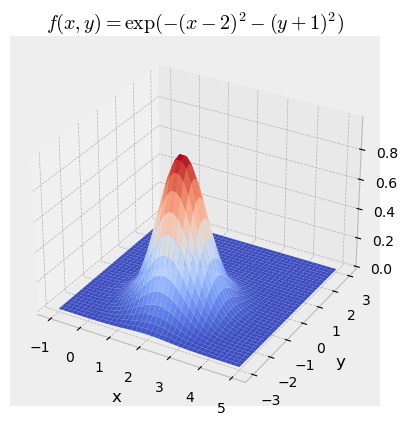

In [104]:
# The ranges of x and y values that we'd like to include in the contour plot.
x_range = np.linspace(-1, 5, 40)
y_range = np.linspace(-3, 3, 40)

# Form all possible x-y pairs in these ranges.
X, Y = np.meshgrid(x_range, y_range)

# Make the surface plot.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, f(X, Y), cmap='coolwarm')

ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.set_zlabel('f(x, y)')
ax.set_title(r'$f(x,y)=\exp(-(x-2)^2 - (y+1)^2)$');
plt.show()


The corresponding contour plot where darker rings represent lower values and lighter rings indicate higher values,  is shown below

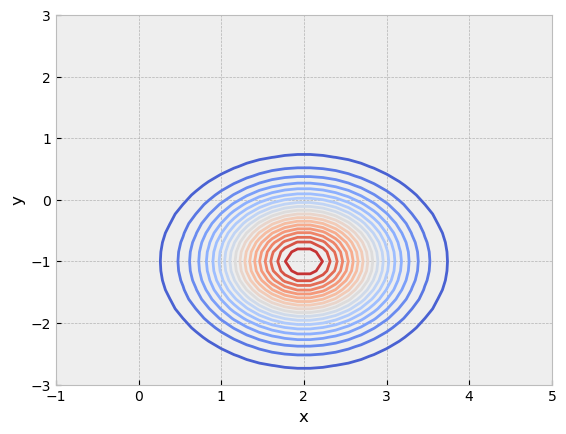

In [105]:
plt.contour(X, Y, f(X, Y), 20, cmap='coolwarm');
plt.xlabel('x')
plt.ylabel('y');

The gradient $\nabla f$ is obtained by differentiating $f$ with respect to the inputs $x$ and $y$

In [106]:
def gradient_of_f(x, y):
    return (-2*(x-2)*f(x, y), -2*(y+1)*f(x, y))

This gradient **ascent** algorithm (`gradient_ascent`)  searches for the values of $x$ and $y$ that give the **maximum** of $f(x, y)$.

The inputs to `gradient_ascent` are the initial values ($x_0$, $y_0$); a threshold that defines  the termination criterion for how small the gradient magnitude should be at the maximum; and a learning rate.

The function returns the $x$ and $y$ values that maximize the function. Additionally, for educational reasons, it provides a history list containing all the estimated 
$x$ and $y$ points evaluated throughout the optimization process.

In [107]:
def gradient_ascent(x_init, y_init, 
                    threshold = 0.001,
                    learningRate = 0.6):
    x = x_init
    y = y_init
    history = [(x, y)]
    done = False
    while not done:        
        gxy = gradient_of_f(x, y)
        x += learningRate * gxy[0]
        y += learningRate * gxy[1]
        history.append([x, y])
        if np.linalg.norm(gxy) < threshold:
            done = True
    return (x, y), history

The results presented below demonstrate that the algorithm approaches the global optimal values at $x$ and $y$ quite closely.

In [108]:
(x, y), history = gradient_ascent(0, 0)

x, y

(2.0000441824408663, -1.0000220912204332)

The contour plot includes the intermediate estimates $x_i,y_i$ (red dots) as it climbs from (0, 0) towards the peak (2, -1).

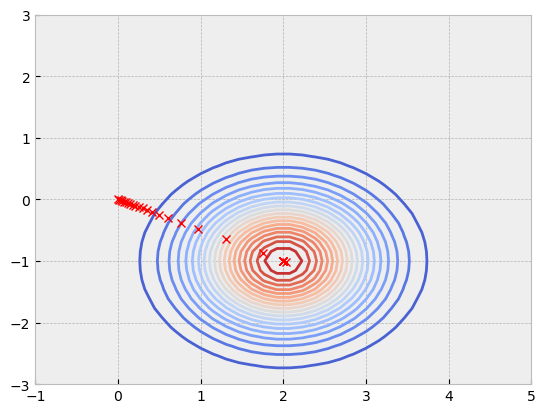

In [109]:
# Make the contour plot.
plt.contour(X, Y, f(X, Y), 20, cmap='coolwarm')

# Plot the gradient ascent path.
plt.plot([x for x, _ in history], [y for _, y in history], 'rx');


## Minimzing a Linear Least Squares using Gradient Descent

This next example shows the **minimization** of a loss function using gradient descent.
The objective function is the standard linear least squares:
$$
\mathcal{L}(w) =  \sum_{i=1}^N (f_w(x_i) - y_i)^2 = \frac{1}{N} \sum_{i=1}^N (w^\top x_i - y_i)^2 
$$

where $f_w(x)=w^\top x$.

Linear least squares regression has an *analytical* (exact) solution that, as discussed ealier in the course,  can be found using the projection / pseudoinverse using the designmatrix $A$:

$$
w = (A^\top\cdot A)^{-1} \cdot A^\top \cdot y
$$


However this example will use gradient descent for linear regression to exemplify
*   gradient descent on a simple and pedagogical example
*  that when the design matrix $A$ is very large it may become computationally intractable to compute the full solution using pseudo inverse. In fact this is the  reason that some of scikit-learn's  linear regression training algorithms (e.g. [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) etc) are based on iterative optimization rather than using the exact solution.



In [110]:
class LeastSquaresRegressorGD():

    def __init__(self, n_iter=20, tolerance=1e-5, learningRate=0.1):
        self.n_iter = n_iter
        self.tolerance = tolerance
        self.learningRate = learningRate
    def predict(self, X):
        return X.dot(self.w)  
    
    def fit(self, X, Y):
        n_instances, n_features = X.shape
        print("N-Features: %d" % n_features)
        self.w = np.zeros(n_features)
        print("Initial w %d" % self.w)
        self.history = []
        self.ws = []
        self.ws.append(self.w[0])
        for i in range(self.n_iter):            
           
            # predictions on the whole training set using the current estimate theta
            # this is a vector of predicted outputs
            G = X.dot(self.w)
            
            # vector of error values
            Error = G - Y

            # the loss value for the whole of the training set is the mean of the squared errors
            total_loss = np.mean(Error**2)

            # and the gradient is also computed over the whole training set, and the mean over the
            # individual gradients computed.
            gradient_w = np.mean(2*Error*X.T, axis=1)

            # if the gradient vector is small enough, terminate early
            if np.linalg.norm(gradient_w) <= self.tolerance:
                break
            
            # update the weights in the direction of reducing the error for the whole training set. 
            self.w -= self.learningRate*gradient_w
            self.ws.append(self.w[0])
            self.history.append(total_loss)
            
        print('GD final loss (iteration {}): {:.4f}'.format(i+1, total_loss))

### Testing the training algorithm on a synthetic dataset

The example uses univariate data linear (one input feature - the slope) model with gaussian noise. 

Text(0.5, 1.0, 'Synthetic dataset')

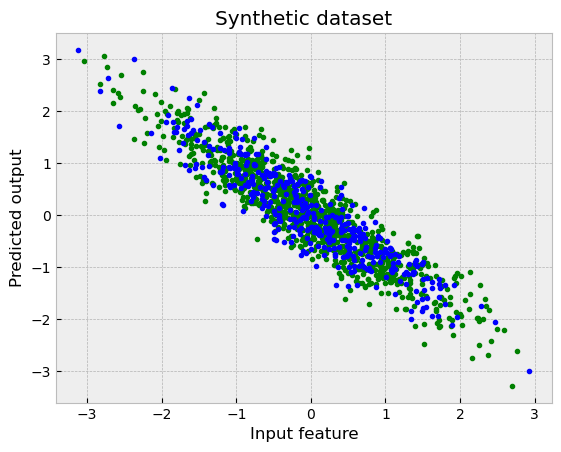

In [111]:
np.random.seed(0)
numSamples = 1000
slope = -0.9
intercept = 0.4
testsetSize= 400
Xtrain = np.random.normal(size = (numSamples, 1))
Ytrain = slope * Xtrain[:,0] + intercept * np.random.normal(size=Xtrain.shape[0])

Xtest = np.sort(np.random.normal(size = (testsetSize, 1)))
Ytest = slope * Xtest[:,0] + intercept * np.random.normal(size=Xtest.shape[0])

plt.plot(Xtrain, Ytrain, 'g.');
plt.plot(Xtest, Ytest, 'b.');

plt.xlabel("Input feature")
plt.ylabel("Predicted output")
plt.title("Synthetic dataset")


You can experiment with how the learning rate impacts the algorithm's convergence. A very low learning rate leads to slow convergence, as the algorithm takes small steps towards the optimal solution. Conversely, a very high learning rate can also hinder convergence, either by causing the algorithm to oscillate and "jump around" too much, or by preventing it from converging entirely.

In [119]:

gd_regression = LeastSquaresRegressorGD(n_iter=20, learningRate=0.25, tolerance=0.005)
gd_regression.fit(Xtrain, Ytrain)


N-Features: 1
Initial w 0
GD final loss (iteration 20): 0.1662


The learning rate in the example is deliberately set low to clearly illustrate how each iteration improves the fit. Adjusting the learning rate to approximately 0.1 will result in much faster convergence.

Plotting the `history`  during training reveals the progress of the optimization 
The gradient descent algorithm performs reasonably well (but poorly compared to more sophisticated models). That is unsurprising since the algortihm  has not made any updates by that point.

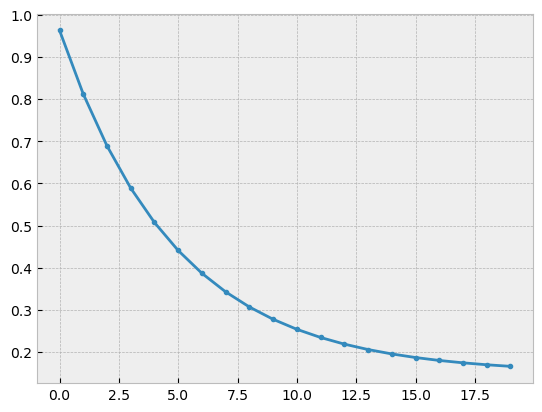

In [120]:
plt.plot(gd_regression.history, '.-')


The evaluation of the MSE on the test set reveals that the model found by the training algorithm is reasonably good.

In [114]:
print(mean_squared_error(Ytest, gd_regression.predict(Xtest)))

0.1445019620965077


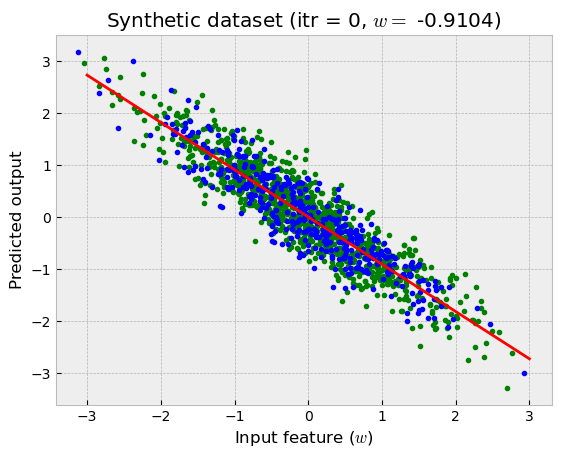

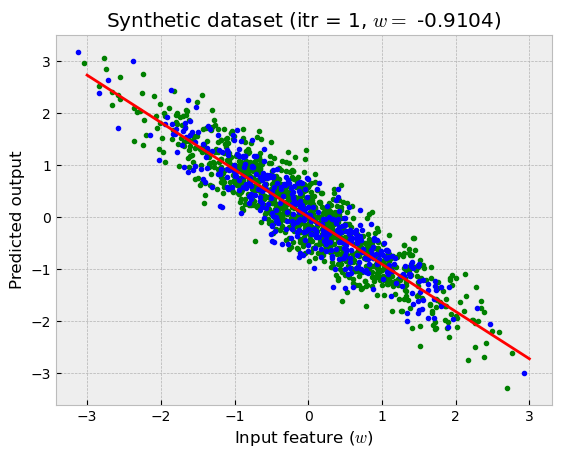

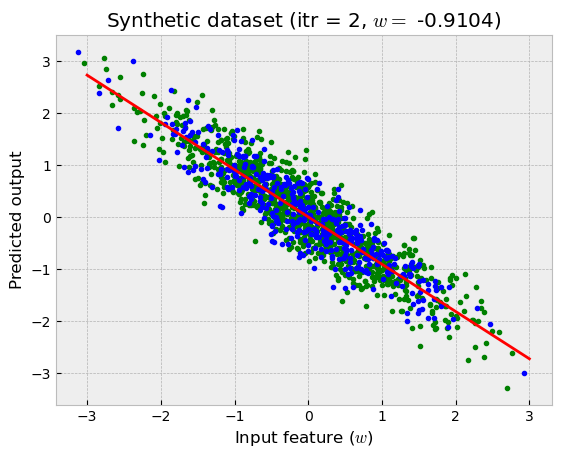

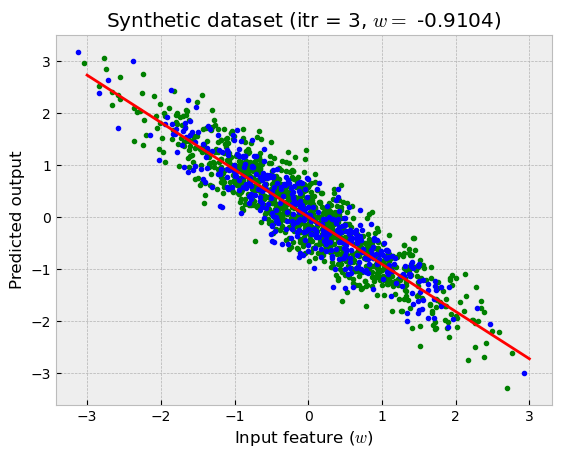

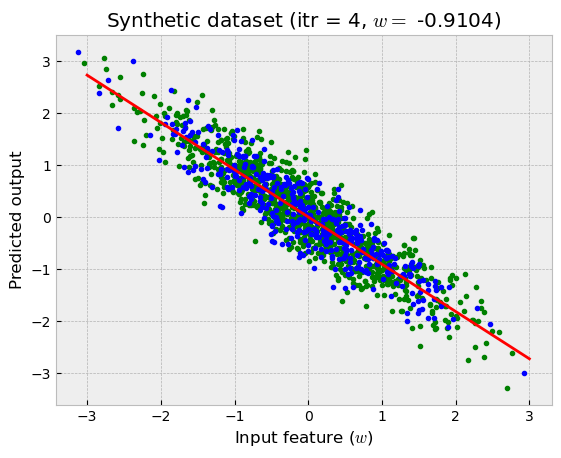

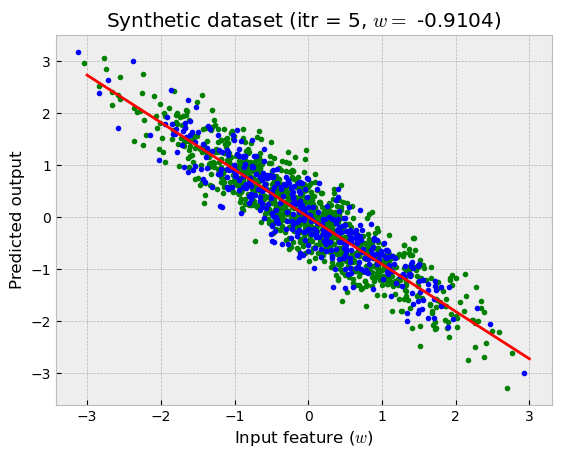

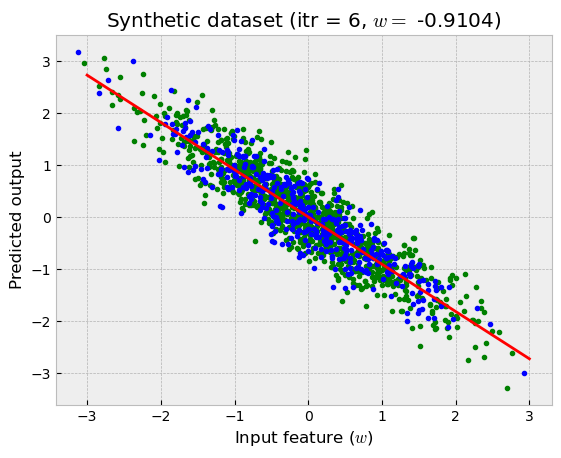

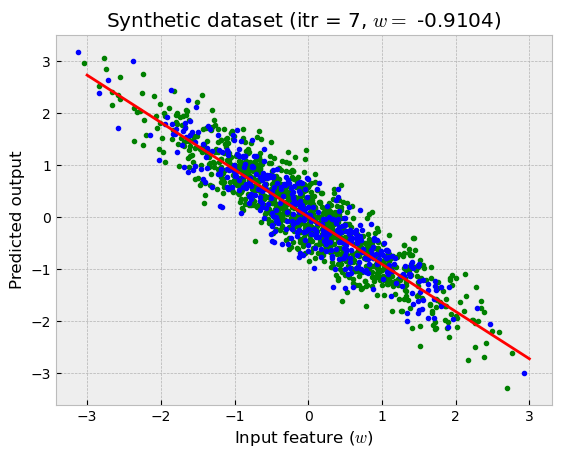

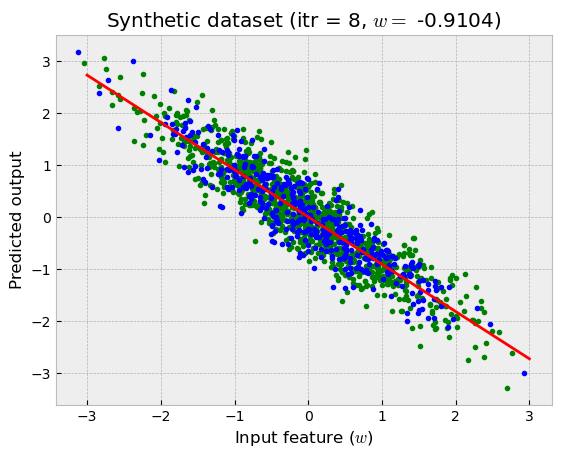

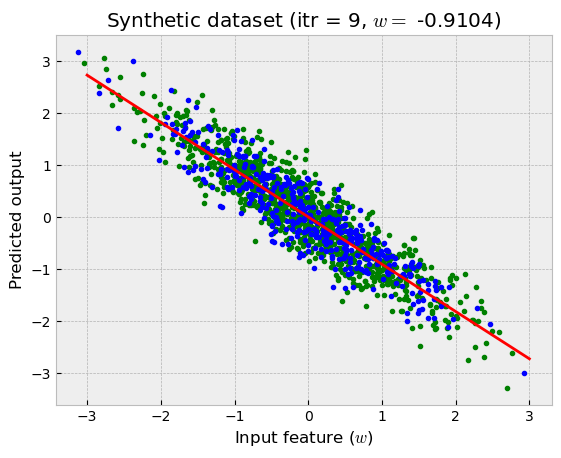

In [115]:

for i, theta in enumerate(gd_regression.ws):
    # Show only the first 10 figures due
    if(i>10):
        break
    gd_regression.theta = theta
    y1 =  gd_regression.predict(np.array(-3))
    y2 =  gd_regression.predict(np.array(3))
    
    plt.figure()

    plt.plot(Xtrain, Ytrain, 'g.');
    plt.plot(Xtest, Ytest, 'b.');

    plt.xlabel(f"Input feature ($w$)")
    plt.ylabel("Predicted output")
    plt.title(r"Synthetic dataset (itr = %d, $w=$ %2.4f)" % (i,gd_regression.w))
    
        
    plt.plot([-3,3],[y1,y2],'r-')